## Mode Share Predictions - 2018 PSRC Travel Survey 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from seaborn.linearmodels import corrplot,symmatplot

#from sklearn.linear_model import LogisticRegression
#from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import log_loss
#from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

from datetime import datetime

DATA_DIR = '../data/'

#https://jmetzen.github.io/2015-01-29/ml_advice.html

/anaconda3/lib/python3.6/site-packages/seaborn/linearmodels.py:5: UserWarning: The `linearmodels` module has been renamed `regression`.
  warnings.warn(msg)


ImportError: cannot import name 'corrplot'

## Pre-processing
Clean missing data and create readable classifications for analytical information.
Aggregate data to census blockgroup for regression analysis.

In [44]:
df_Trip_Household_Merged = pd.read_csv(DATA_DIR + 'Trip_Household_Merged.csv')

# Filter trips that end outside seattle
df_Trip_Household_Merged = df_Trip_Household_Merged[df_Trip_Household_Merged['uv_dest'] != "Outside Seattle"]

# drop data that are not in urban villages
df_Trip_Household_Merged = df_Trip_Household_Merged[(df_Trip_Household_Merged['uv_origin'] != "Outside Seattle") &
                                                    (df_Trip_Household_Merged['uv_origin'] != "Outside Villages")]

# Create dummy variables for departure time period
depart_period_dummies = pd.get_dummies(df_Trip_Household_Merged['depart_period'])

df_Trip_Household_Merged['weekday_am'] = depart_period_dummies['Weekday AM']
df_Trip_Household_Merged['weekday_mid'] = depart_period_dummies['Weekday Mid']
df_Trip_Household_Merged['weekday_pm'] = depart_period_dummies['Weekday PM']
df_Trip_Household_Merged['weekday_late'] = depart_period_dummies['Late Night']

# Create dummie variables for residency duration, with justs two categories, under and over 5 years (see codebook)
df_Trip_Household_Merged['residency_under5'] = np.where((df_Trip_Household_Merged['res_dur']<=3), 1, 0)
df_Trip_Household_Merged['residency_over5'] = np.where((df_Trip_Household_Merged['res_dur']>3), 1, 0)

# Create dummie variables for home ownership
df_Trip_Household_Merged['hh_rent'] = np.where((df_Trip_Household_Merged['rent_own']==2), 1, 0)
df_Trip_Household_Merged['hh_own'] = np.where((df_Trip_Household_Merged['rent_own']==1), 1, 0)

# Create dummie variables for income
df_Trip_Household_Merged['income_under25'] = np.where((df_Trip_Household_Merged['hhincome_broad']==1), 1, 0)
df_Trip_Household_Merged['income_25_50'] = np.where((df_Trip_Household_Merged['hhincome_broad']==2), 1, 0)
df_Trip_Household_Merged['income_50_75'] = np.where((df_Trip_Household_Merged['hhincome_broad']==3), 1, 0)
df_Trip_Household_Merged['income_75_100'] = np.where((df_Trip_Household_Merged['hhincome_broad']==4), 1, 0)
df_Trip_Household_Merged['income_over100'] = np.where((df_Trip_Household_Merged['hhincome_broad']==5), 1, 0)

df_Trip_Household_Merged['o_tract'] = df_Trip_Household_Merged['o_bg'].astype(str).apply(lambda x: x[:9])

# aggregate by geography of origin
#geography = ['o_bg']
geography = ['o_tract']
#geography = ['uv_origin']


trainFeatures = ['google_duration', 'trip_path_distance', 'hhsize', 'hh_rent','hh_own',
            'depart_time', 'numchildren', 'vehicle_count','gender_female', 'gender_male',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late','residency_under5','residency_over5',
                'income_under25', 'income_25_50', 'income_75_100','income_75_100','income_over100',
                 'drive_alone','race_white']

aggDict = {}
for feature in trainFeatures:
    aggDict[feature]=[sum]

# Apply trip weights prior to aggregation
for feature in trainFeatures:
    df_Trip_Household_Merged[feature] = df_Trip_Household_Merged['trip_weight_revised'] * df_Trip_Household_Merged[feature]

aggDict['trip_weight_revised'] =[sum]

data = df_Trip_Household_Merged.groupby(geography, as_index=False).agg(aggDict)
data.columns = data.columns.get_level_values(0)

# Reapply column weights to obtain averages for each location
for feature in trainFeatures:
   data[feature] = data[feature] / data['trip_weight_revised']

# Create label for geographies under the citywide mean of 38%
data['drive_alone_threshold'] = np.where((data['drive_alone'] <= .40), 1, 0)

for feature in trainFeatures:
    data = data[data[feature].notnull()]
print (data)

# drop outlier
#data = data[data['drive_alone'] < .3]
#data = data[data['trip_wt_final'] > 1000]

#print(data.columns)
#data.to_csv(DATA_DIR + 'df_Trip_Processed_Agg_Village_Origin.csv', mode='w', header=True, index=False)


      o_tract  google_duration  trip_path_distance    hhsize   hh_rent  \
0   530330004         8.934511            3.013055  1.852809  0.760282   
1   530330006         7.499766            1.492876  2.399104  0.277968   
2   530330007        19.085497            6.263151  2.683006  0.152733   
3   530330012        10.131036            3.287429  2.409952  0.255162   
4   530330013        11.735883            4.856710  3.027400  0.360580   
5   530330016        11.141164            2.612950  2.224713  0.169714   
6   530330017         9.417741            2.158750  1.750296  0.376678   
7   530330018        10.406941            2.496829  2.624285  0.108763   
8   530330019        12.631208            2.257535  3.069605  0.213345   
9   530330026         8.693167            1.857625  3.934498  0.188063   
10  530330030         9.837955            2.129792  3.169895  0.240144   
11  530330032        13.890643            3.740832  2.738439  0.657316   
12  530330033         9.947028        

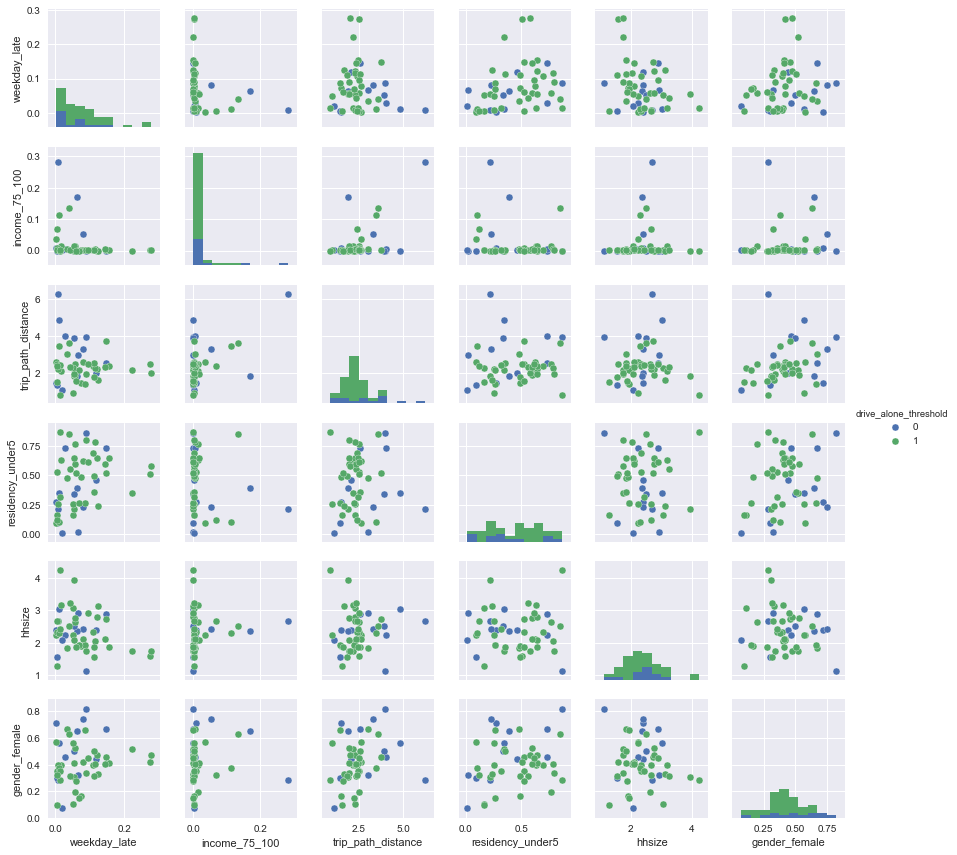

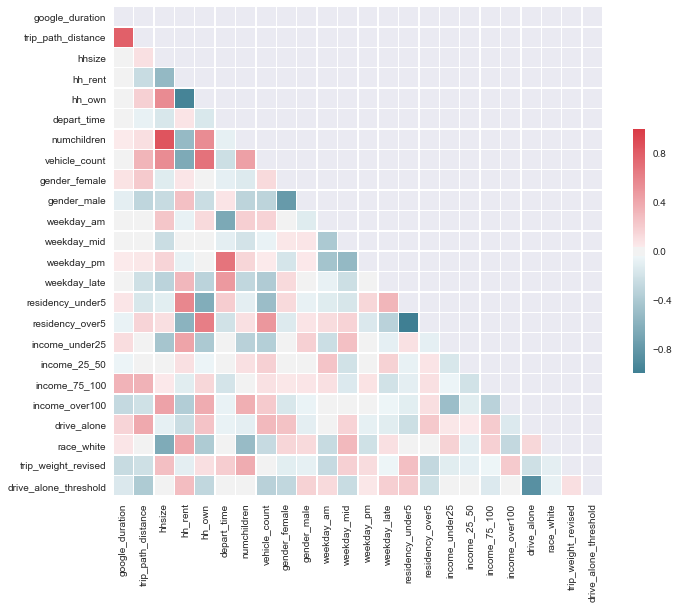

In [45]:
# Correlation charts to help identify features

_ = sns.pairplot(data[:50], vars=['weekday_late','income_75_100' , 'trip_path_distance', 
                                  'residency_under5', 'hhsize','gender_female'], hue="drive_alone_threshold", size=2)

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear Regression

Multivariate cross validation with a linear regression model. 
SB NOTE: This is a working draft. The results are extremly over-fit. We
will try to work on this before August.

Mean squared error: 0.000
Variance score: 1.000


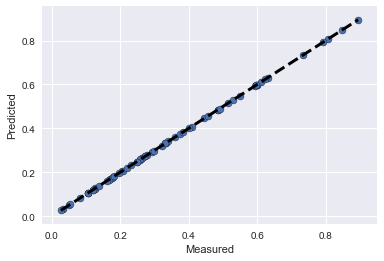

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


Allfeatures = ['google_duration', 'trip_path_distance', 'hhsize', 'residency_under5',
            'numchildren', 'vehicle_count','hh_own',
           'weekday_am', 'weekday_mid','weekday_pm','weekday_late','gender_female'
            'income_under25', 'income_25_50','income_75_100','income_over100']

features = ['google_duration', 'trip_path_distance', 'residency_under5',
           'income_over100','gender_female','race_white']

#NORMALIZE THESE FEATURES!!

feature_list = features

target = ["drive_alone"]

def train_and_cross_val(cols, target):
    
   # Split into features & target.
    features = data[cols]
    target = data[target]

    variance_values = []
    mse_values = []
    
    # kFold instance
    kf = KFold(n=len(data), n_folds=5, shuffle=True, random_state = 3)
    
    # Iterate through each fold
    for train_index, test_index in kf:

        #Training and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # Instantiate the model
        model = LinearRegression(normalize=True)
     #   model = Pipeline([('poly', PolynomialFeatures(degree=3)),
     #                     ('linear', LinearRegression(fit_intercept=False))])

   
        # Fit model to features and target
        model.fit(X_train,y_train)
    
        # Make predictions
        predictions = model.predict(X_test)
    
        # Calulate mse and variance for this fold
        mse = mean_squared_error(y_test, predictions)
        variance = r2_score(y_test, predictions)
    
        # Append to arrays to do calculate overall 
        # average mse and variance values.
        variance_values.append(variance)
        mse_values.append(mse)
        print (variance)

    # Compute average mse and variance values.
    avg_mse = np.mean(mse_values)
    avg_var = np.mean(variance_values)
    
    print ("mse: " + str(mse)," variance: " + str(variance))
        
    return(avg_mse, avg_var)


def train_and_predict(cols, target):

    # Split into features & target.
    features = data[cols]
    target = data[target]

    # Instantiate the model
    #model = LinearRegression(normalize=True)
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                        ('linear', LinearRegression(fit_intercept=False))])

    
    # fit the model
    model.fit(features,target)
    
    # Make predictions
    predictions = model.predict(features)
    mse = mean_squared_error(target, predictions)
    variance = r2_score(target, predictions)
    
   # print (model.intercept_, model.coef_)

    # The mean squared error
    print("Mean squared error: %.3f"
      % mean_squared_error(target, predictions))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.3f' % r2_score(target, predictions))

    fig, ax = plt.subplots()
    ax.scatter(target, predictions, edgecolors=(0, 0, 0))
    ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=3)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    
    df_results = pd.DataFrame(feature_list)
    #df_results['feature'] = features
    #df_results['coefficient'] = model.coef_[0]
    #print (df_results)
    
train_and_predict(features, target)
#train_and_cross_val(features, target)

